In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib widget

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=1
# diffusion="5.0percent"
diffusion="nodiff"
# file_id = "1"
file_id = "2954"
# file_id = "2638"


# hits = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_{diffusion}_filtered.h5", "MC/hits")
# hits_true = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_nexus_filtered.h5", "MC/hits")


# hits_true = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_smear_{file_id}.h5", "MC/hits")
# hits      = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_{diffusion}_smear_{file_id}.h5", "MC/hits")


hits_true = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_1bar_nexus_2954.h5", "MC/hits")
hits = pd.read_hdf("../data/ATPC_Tl/ATPC_Tl_1bar_smear_2954.h5", "MC/hits")

display(hits)

event_list = hits.event_id.unique()

eid=event_list[9]

data = hits[hits.event_id ==eid]
# data = CutandRedistibuteEnergy(data, 0.0004)

data_true = hits_true[hits_true.event_id == eid]
data_true["z"] = data_true["z"]+3000

# print(hits.event_id.unique())

,event_id,x,y,z,energy
0,103725000,2593.829102,-1523.925049,877.155029,0.001984
1,103725000,2592.800537,-1521.920532,877.760681,0.000124
2,103725000,2595.914307,-1531.023438,878.835144,0.002554
3,103725000,2591.013184,-1518.843140,879.318359,0.001736
4,103725000,2596.769043,-1533.632690,879.770691,0.000992
...,...,...,...,...,...
62338,103725059,-2559.582764,-1110.381226,1114.903320,0.001860
62339,103725059,-2561.066406,-1101.292358,1116.353516,0.003596
62340,103725059,-2561.947510,-1104.781982,1117.195435,0.002827
62341,103725059,-2562.315674,-1105.450317,1117.598145,0.000273


In [83]:

Diff_smear, energy_threshold, diff_scale_factor, radius_sf, voxel_sf = InitializeParams(pressure, diffusion)

print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Voxel scale factor is: ",      voxel_sf)

mean_sigma = round(diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean()))
print("mean_sigma:", mean_sigma)

# Calculate the detector half-length
det_size = int(np.cbrt(6000**3/pressure)/2.0) 

# This shifts the z pos of the events so 0 is at anode
z_shift = det_size

zmin=-det_size + z_shift - mean_sigma/2 
xmin=-det_size - mean_sigma/2 
ymin=-det_size - mean_sigma/2 


Diffussion smear is:  0.1 mm/sqrt(cm)
Energy threshold is:  0.0 keV
diffision scale factor is:  7
Radius scale factor is:  7
Voxel scale factor is:  2.1
mean_sigma: 13


In [84]:
reco_DE_event = data.copy()

# voxel size and parameters
voxel_size = mean_sigma  # mm
threshold = voxel_size*voxel_sf

df_merged = GroupHits(reco_DE_event, xmin, ymin, zmin, voxel_size, threshold)
display(df_merged)



Total groups created: 2


,event_id,x,y,z,energy,group_id
0,103725009,-1316.844727,2833.060791,2494.001465,0.029834,0
1,103725009,-1297.461914,2799.191406,2594.919922,0.005010,1
2,103725009,-1299.684692,2800.964844,2595.051025,0.002356,1
3,103725009,-1302.021973,2802.809082,2595.074951,0.000967,1
4,103725009,-1304.909180,2805.216797,2595.193848,0.002158,1
...,...,...,...,...,...,...
976,103725009,-1179.951050,2424.369141,3731.809082,0.004786,1
977,103725009,-1173.834961,2430.488525,3732.135254,0.001314,1
978,103725009,-1179.019897,2426.364746,3732.545410,0.003224,1
979,103725009,-1177.814819,2427.835449,3732.616455,0.000818,1


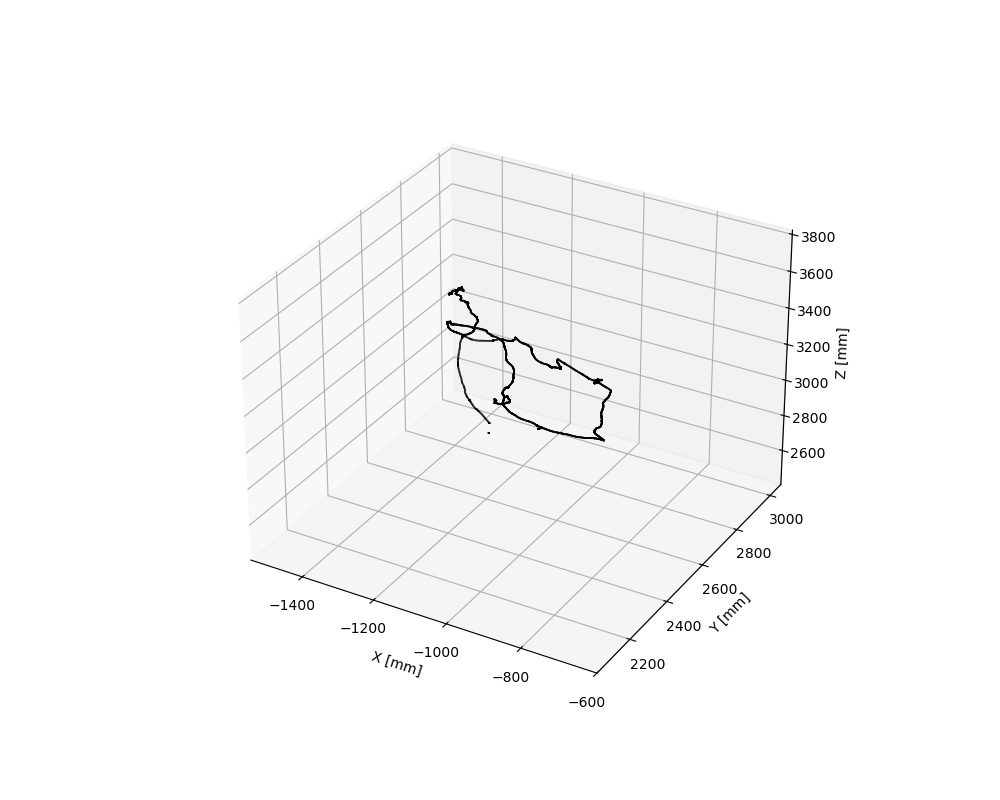

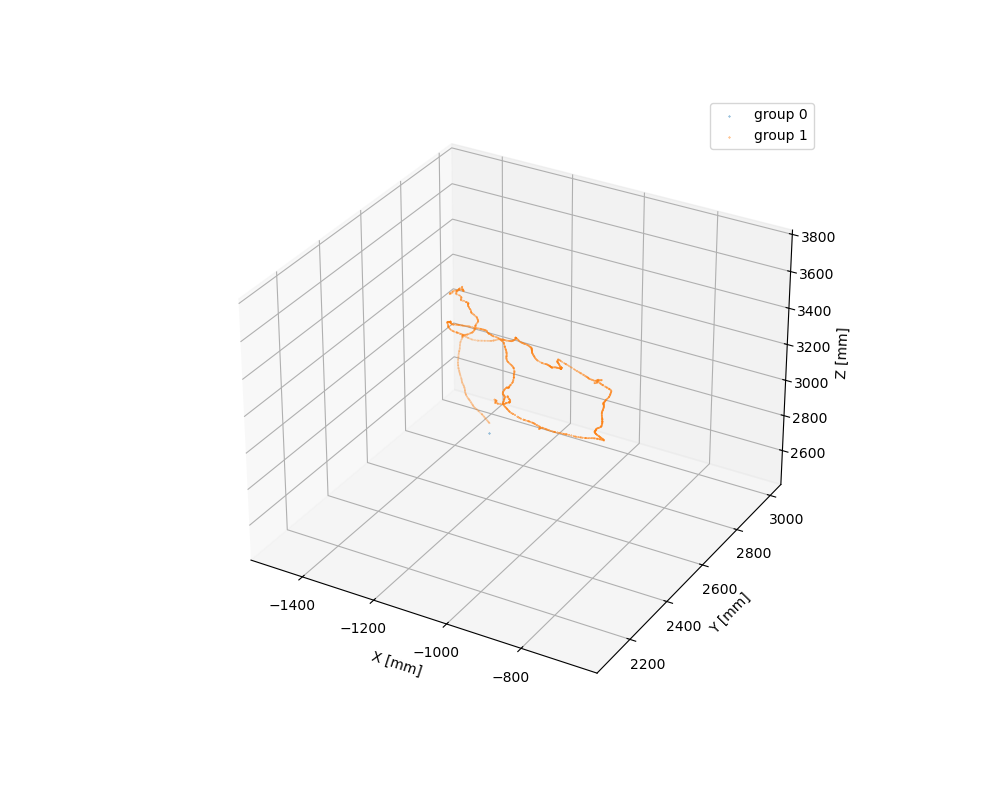

In [85]:

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(data_true['x'], data_true['y'], data_true['z'],c="k", s=0.1)
# ax1.scatter(data['x'], data['y'], data['z'],c="k", s=0.1)

ax1.set_xlabel("X [mm]")
ax1.set_ylabel("Y [mm]")
ax1.set_zlabel("Z [mm]")


fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
for gid in sorted(df_merged["group_id"].unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    ax1.scatter(temp_df['x'], temp_df['y'], temp_df['z'], s=0.1, label = f"group {gid}")
    # ax1.scatter(data['x'], data['y'], data['z'],c="k", s=0.1)

    ax1.set_xlabel("X [mm]")
    ax1.set_ylabel("Y [mm]")
    ax1.set_zlabel("Z [mm]")
    ax1.legend()
